# 02_tml_baseline

We will use the train/test data generated from *00_create_dataset.ipynb* and use basic machine learning models to generate a baseline reference of model performance on our data. We will then decide on how to improve the various models after this

In [ ]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [ ]:
# load data
train = pd.read_csv(root_dir/"data/train.csv")
test = pd.read_csv(root_dir/"data/test.csv")
print("data loaded")

data loaded


In [ ]:
# check shape
print(train.shape)
print(test.shape)

(280145, 138)
(120504, 138)


In [ ]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


In [ ]:
# scaling data to make it easier for models to train
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)

# test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
x_test = scaler.transform(x_test)

# Helper functions

In [ ]:
# constants
SEED = 42

In [ ]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [ ]:
def model_scores(model, test=test, x_test=x_test, y_test=y_test):
  y_pred = model.predict(x_test) 

  print("Utility score: ", utility_score(test, y_pred))
  print("Accuracy: ", accuracy_score(y_test, y_pred))
  
  print("Confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(3, 3))
  ax.imshow(cm)
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
      for j in range(2):
          ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  plt.show()  

  print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
  fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

# Random Forest Classifier

In [ ]:
# import model
from sklearn.ensemble import RandomForestClassifier

# settings to vary
n_estimators = [50, 100, 200, 400, 800]
max_depths = [2,4,8,16]
max_features = [None, 'sqrt', 'log2']



Random Forest model: n_estimators=50, max_depth=2, max_feature=None
Utility score:  206.09310310940853
Accuracy:  0.5057093540463388
Confusion matrix


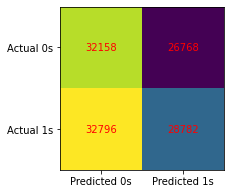

AUC_ROC


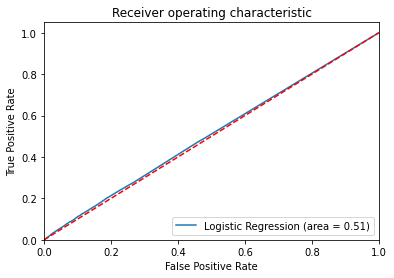



Random Forest model: n_estimators=50, max_depth=2, max_feature=sqrt
Utility score:  214.47438593125554
Accuracy:  0.5084229569142933
Confusion matrix


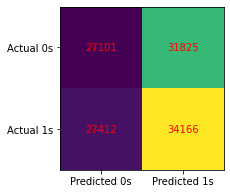

AUC_ROC


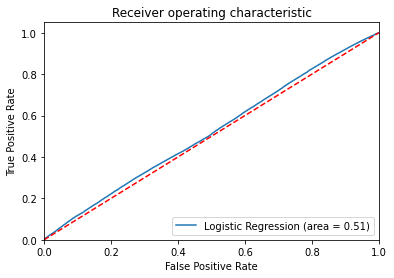



Random Forest model: n_estimators=50, max_depth=2, max_feature=log2
Utility score:  252.51283144127734
Accuracy:  0.5097673106286928
Confusion matrix


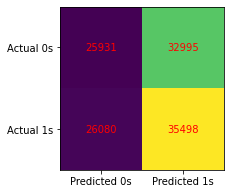

AUC_ROC


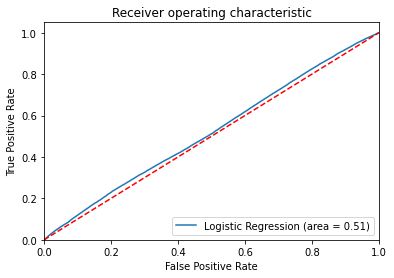



Random Forest model: n_estimators=50, max_depth=4, max_feature=None
Utility score:  156.00725220222367
Accuracy:  0.5068545442474939
Confusion matrix


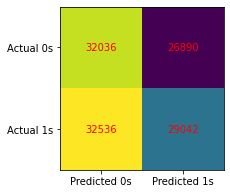

AUC_ROC


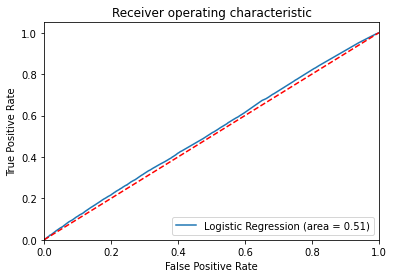



Random Forest model: n_estimators=50, max_depth=4, max_feature=sqrt
Utility score:  238.47048514755284
Accuracy:  0.5110535749850628
Confusion matrix


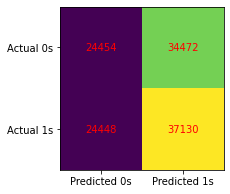

AUC_ROC


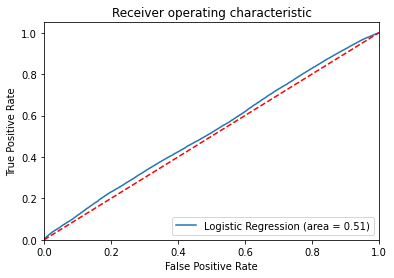



Random Forest model: n_estimators=50, max_depth=4, max_feature=log2
Utility score:  276.9911956935821
Accuracy:  0.5129705238000398
Confusion matrix


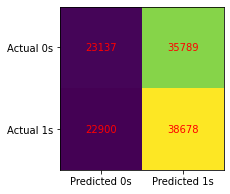

AUC_ROC


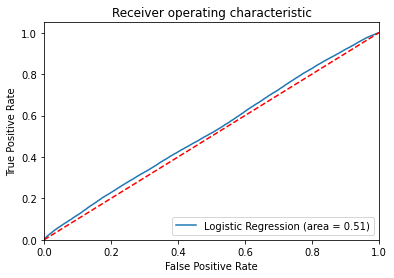



Random Forest model: n_estimators=50, max_depth=8, max_feature=None
Utility score:  395.0831917221044
Accuracy:  0.5152194118037575
Confusion matrix


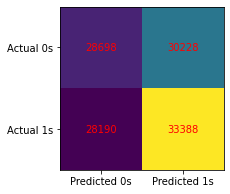

AUC_ROC


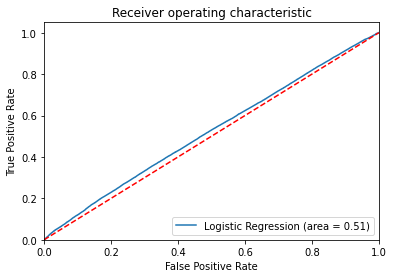



Random Forest model: n_estimators=50, max_depth=8, max_feature=sqrt
Utility score:  240.65638772551497
Accuracy:  0.5149953528513577
Confusion matrix


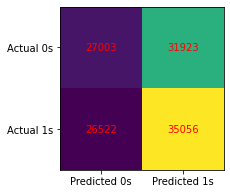

AUC_ROC


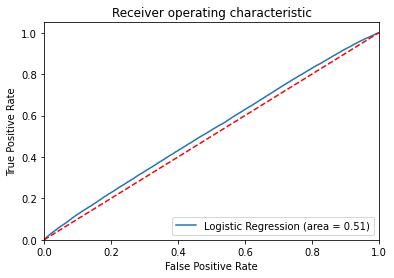



Random Forest model: n_estimators=50, max_depth=8, max_feature=log2
Utility score:  126.46883401067015
Accuracy:  0.5127381663679214
Confusion matrix


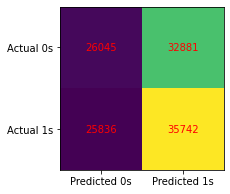

AUC_ROC


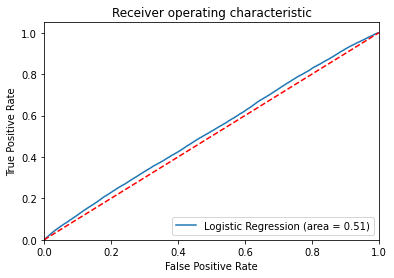



Random Forest model: n_estimators=50, max_depth=16, max_feature=None
Utility score:  584.955934967066
Accuracy:  0.5163811989643498
Confusion matrix


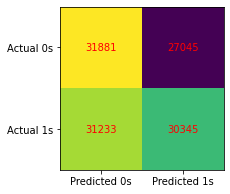

AUC_ROC


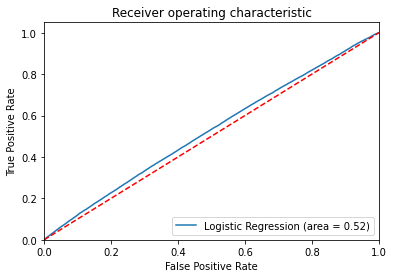



Random Forest model: n_estimators=50, max_depth=16, max_feature=sqrt
Utility score:  165.1329004701356
Accuracy:  0.5154268737967205
Confusion matrix


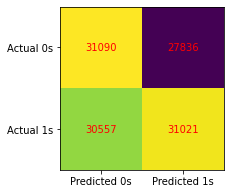

AUC_ROC


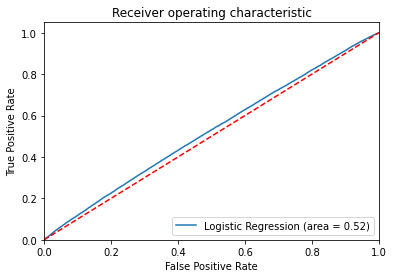



Random Forest model: n_estimators=50, max_depth=16, max_feature=log2
Utility score:  146.23566088412224
Accuracy:  0.5120161986324105
Confusion matrix


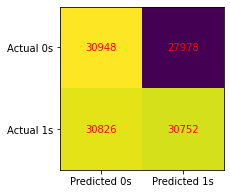

AUC_ROC


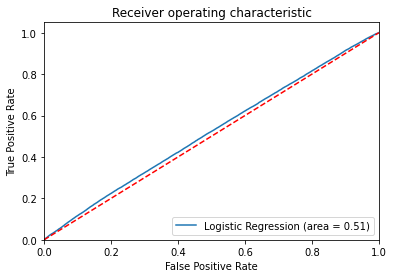



Random Forest model: n_estimators=100, max_depth=2, max_feature=None
Utility score:  212.73500102647836
Accuracy:  0.5056844586071831
Confusion matrix


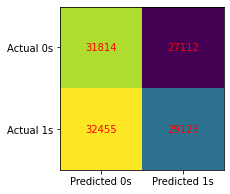

AUC_ROC


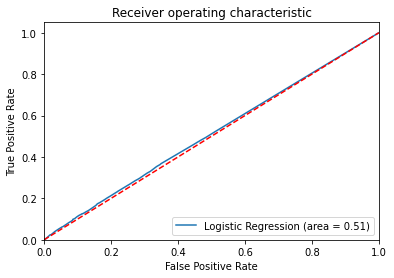



Random Forest model: n_estimators=100, max_depth=2, max_feature=sqrt
Utility score:  219.00827414321535
Accuracy:  0.509061939852619
Confusion matrix


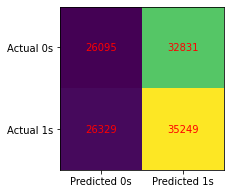

AUC_ROC


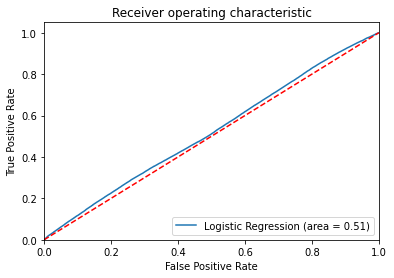



Random Forest model: n_estimators=100, max_depth=2, max_feature=log2
Utility score:  201.4945737274189
Accuracy:  0.5082154949213304
Confusion matrix


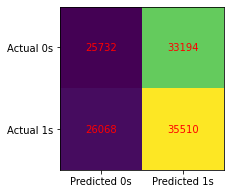

AUC_ROC


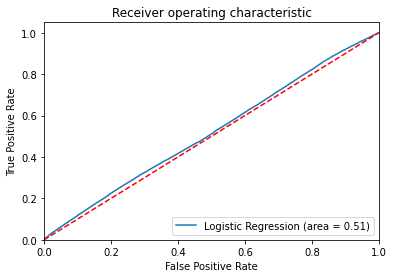



Random Forest model: n_estimators=100, max_depth=4, max_feature=None
Utility score:  338.9912675462994
Accuracy:  0.5087963885016265
Confusion matrix


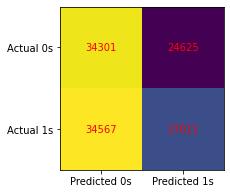

AUC_ROC


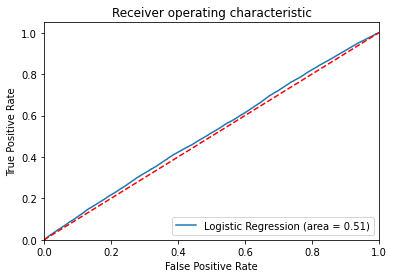



Random Forest model: n_estimators=100, max_depth=4, max_feature=sqrt
Utility score:  243.3193842852427
Accuracy:  0.512007900152692
Confusion matrix


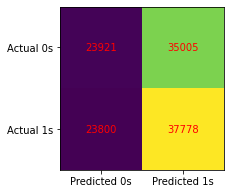

AUC_ROC


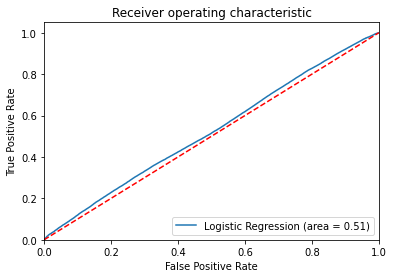



Random Forest model: n_estimators=100, max_depth=4, max_feature=log2
Utility score:  256.5761391024016
Accuracy:  0.5122568545442475
Confusion matrix


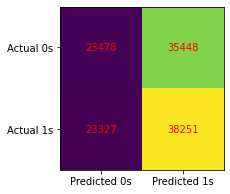

AUC_ROC


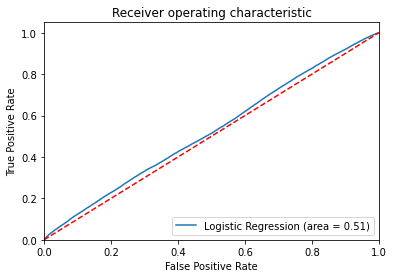



Random Forest model: n_estimators=100, max_depth=8, max_feature=None


In [ ]:
# iterate over settings for the model
for n_estimator in n_estimators:
  for max_depth in max_depths:
    for max_feature in max_features:
      print(f"\n\nRandom Forest model: n_estimators={n_estimator}, max_depth={max_depth}, max_feature={max_feature}")    

      model = RandomForestClassifier(
          n_estimators=n_estimator, 
          max_depth=max_depth,
          max_features=max_feature
      )

      model.fit(x_train, y_train)
      model_scores(model)

# Conclusion

Successfully ran for n_estimators = 50, maximum score obtained by model w params max_depth=8, max_feature =None

* Utility score: 395.0831917
* Accuracy: 0.5152194118

Models returned a minimum of 126 utility score ranging up to 395 utility score.